<a target="_blank" href="https://colab.research.google.com/github/eeg2025/startkit/blob/main/challenge_2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 2: Predicting the p-factor from EEG

The psychopathology factor (P-factor) is a widely recognized construct in mental health research, representing a common underlying dimension of psychopathology across various disorders.
Currently, the P-factor is often assessed using self-report questionnaires or clinician ratings, which can be subjective, prone to bias, and time-consuming.
**The Challenge 2** consists of developing a model to predict the P-factor from EEG recordings.

The challenge encourages learning physiologically meaningful signal representations and discovery of reproducible biomarkers.
Models of any size should emphasize robust, interpretable features that generalize across subjects,
sessions, and acquisition sites.

Unlike a standard in-distribution classification task, this regression problem stresses out-of-distribution robustness
and extrapolation. The goal is not only to minimize error on seen subjects, but also to transfer effectively to unseen data.

Ensure the dataset is available locally. If not, see the [dataset download guide](https://eeg2025.github.io/data/#downloading-the-data)

## Contents of this start kit

0. Understand the P-factor regression task.
1. Loading the data.
2. Wrap the data into a PyTorch-compatible dataset.
3. Define, train and save a model.

> **Note:** If you need additional explanations on the [`EEGChallengeDataset`](https://eeglab.org/EEGDash/api/eegdash.html#eegdash.EEGChallengeDataset) class, dataloading, [`braindecode`](https://braindecode.org/stable/models/models_table.html)'s deep learning models, or brain decoding in general, please refer to the start-kit of challenge 1 which delves deeper into these topics.

More contents will be released during the competition inside the [`eegdash`](https://eeglab.org/EEGDash/overview.html) [examples webpage](https://eeglab.org/EEGDash/generated/auto_examples/index.html).

We will establish direct communication channels with you over the next two months, resolve platform issues, and discuss other details.

We are going to do weekly one-hour support time to help teams that may have difficulties with any technical aspects that may arise.

We will have closer communication starting next week, 08/09/2025.

Before we begin, I just want to make a deal with you, ok?

This is a community competition with a strong open-source foundation. When I say open-source, I mean volunteer work.

So, if you see something that does not work or could be improved, first, **please be kind**, and we will fix it together on GitHub, okay?

The entire decoding community will only go further when we stop solving the same problems over and over again, and it starts working together.

----
| The tutorial assumes some prior knowledge of deep learning concepts and EEG concepts:|
| --- |
|* Standard neural network architectures, e.g., convolutional neural networks|
|* Optimization by batch gradient descent and backpropagation|
|* Overfitting, early stopping, regularisation |
|* Some knowledge of pytorch and, optionally, of the pytorch Lightning framework|
|* That you know what EEG is |
|* That you have basic familiarity with EEG preprocessing |
|* Like and support open-source :) |
----

In [29]:
!pip install braindecode
!pip install eegdash

In [30]:
from pathlib import Path
import math
import os
import random
from joblib import Parallel, delayed

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch.nn.functional import l1_loss
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets.base import EEGWindowsDataset, BaseConcatDataset, BaseDataset
from braindecode.models import EEGNeX
from eegdash import EEGChallengeDataset

In [31]:
# from pathlib import Path
# from eegdash.dataset import EEGChallengeDataset

⚠️ **In case of colab, before starting, make sure you're on a GPU instance for faster training!** ⚠️

> If running on Google Colab, please request a GPU runtime by clicking `Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU' under 'Hardware accelerator'.

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg = "CUDA-enabled GPU found. Training should be faster."
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting 'T4 GPU'\nunder 'Hardware accelerator'."
    )
print(msg)

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU'
under 'Hardware accelerator'.


## 0. Understanding the P-factor regression task.

The psychopathology factor (P-factor) is a widely recognized construct in mental health research, representing a common underlying dimension of psychopathology across various disorders.
The P-factor is thought to reflect the shared variance among different psychiatric conditions, suggesting that individuals with higher P-factor scores may be more vulnerable to a range of mental health issues.
Currently, the P-factor is often assessed using self-report questionnaires or clinician ratings, which can be subjective, prone to bias, and time-consuming.
In the dataset of this challenge, the P-factor was assessed using the Child Behavior Checklist (CBCL) [McElroy et al., (2017)](https://doi.org/10.1111/jcpp.12849).

The goal of Challenge 2 is to develop a model to predict the P-factor from EEG recordings.
**The feasibility of using EEG data for this purpose is still an open question**.
The solution may involve finding meaningful representations of the EEG data that correlate with the P-factor scores.
The challenge encourages learning physiologically meaningful signal representations and discovery of reproducible biomarkers.
If contestants are successful in this task, it could pave the way for more objective and efficient assessments of the P-factor in clinical settings.

## 1. Loading the data

### A. Define local path and (down)load the data

In this challenge 2 example, we load the EEG 2025 release using EEG Dash.

> **Note:** in this example notebook, we load the contrast change detection task from one mini release only as example. Naturally, you are encouraged to train your models on all complete releases, using data from all the tasks you deem relevant.

In [33]:
# The first step is define the cache folder!
DATA_DIR = Path("data")

# Creating the path if it does not exist
DATA_DIR.mkdir(parents=True, exist_ok=True)

# We define the list of releases to load.
# Here, only release 5 is loaded.
release_list = ["R1","R2","R3","R4","R5"]

all_datasets_list = [
    EEGChallengeDataset(
        release=release,
        task="contrastChangeDetection",
        mini=True,
        description_fields=[
            "subject",
            "session",
            "run",
            "task",
            "age",
            "gender",
            "sex",
            "p_factor",
        ],
        cache_dir=DATA_DIR,
    )
    for release in release_list
]
print("Datasets loaded")
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]

/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(
/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loa

Datasets loaded


### B. Combine the datasets into single one

Here, we combine the datasets from the different releases into a single
``BaseConcatDataset`` object.

In [34]:
all_datasets = BaseConcatDataset(all_datasets_list)
print(all_datasets.description)

raws = Parallel(n_jobs=os.cpu_count())(
    delayed(lambda d: d.raw)(d) for d in all_datasets.datasets
)

          subject  run                     task      age sex  p_factor  \
0    NDARAC904DMU    1  contrastChangeDetection  11.3386   F    -0.603   
1    NDARAC904DMU    3  contrastChangeDetection  11.3386   F    -0.603   
2    NDARAC904DMU    2  contrastChangeDetection  11.3386   F    -0.603   
3    NDARAM704GKZ    1  contrastChangeDetection  10.9449   M     0.062   
4    NDARAM704GKZ    2  contrastChangeDetection  10.9449   M     0.062   
..            ...  ...                      ...      ...  ..       ...   
295  NDARDV245WJG    3  contrastChangeDetection   7.8725   M    -0.759   
296  NDARDV245WJG    1  contrastChangeDetection   7.8725   M    -0.759   
297  NDAREC480KFA    1  contrastChangeDetection  10.4762   M    -0.834   
298  NDAREC480KFA    2  contrastChangeDetection  10.4762   M    -0.834   
299  NDAREC480KFA    3  contrastChangeDetection  10.4762   M    -0.834   

    release_number  ehq_total commercial_use full_pheno  ...  thepresent  \
0               R1      71.17      

KeyboardInterrupt: 

### C. Inspect your data

We can check what is inside the dataset consuming the
MNE-object inside the Braindecode dataset.

The following snippet, if uncommented, will show the first 10 seconds of the raw EEG signal.
We can also inspect the data further by looking at the events and annotations.
We strongly recommend you to take a look into the details and check how the events are structured.

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 50.0 Hz
 meas_date: 2025-08-19 00:00:59 UTC
 nchan: 129
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | his_id: sub-NDARAC904DMU, sex: 2, birthday: 2014-04-17>
>


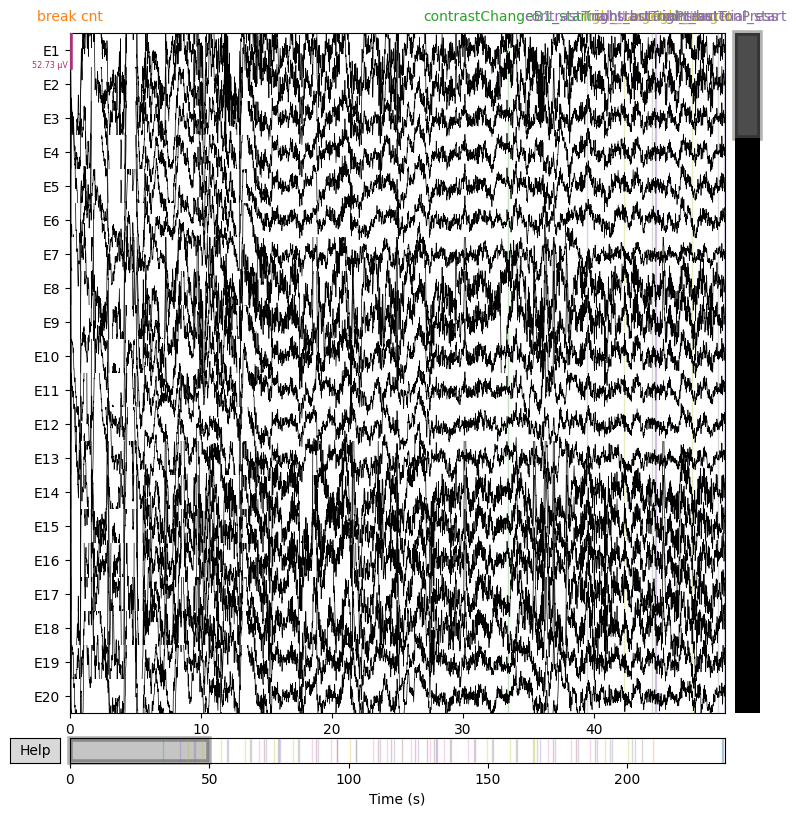

<Annotations | 80 segments: 9999 (1), break cnt (2), ...>


In [35]:
raw = all_datasets.datasets[0].raw  # mne.io.Raw object
print(raw.info)

raw.plot(duration=50, scalings="auto", show=True)

print(raw.annotations)

SFREQ = 100

## 2. Wrap the data into a PyTorch-compatible dataset

The class below defines a dataset wrapper that will extract 2-second windows,
uniformly sampled over the whole signal. In addition, it will add useful information
about the extracted windows, such as the p-factor, the subject or the task.

In [36]:
class DatasetWrapper(BaseDataset):
    def __init__(self, dataset: EEGWindowsDataset, crop_size_samples: int, seed=None):
        self.dataset = dataset
        self.crop_size_samples = crop_size_samples
        self.rng = random.Random(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        X, _, crop_inds = self.dataset[index]

        # P-factor label:
        p_factor = self.dataset.description["p_factor"]
        p_factor = float(p_factor)

        # Additional information:
        infos = {
            "subject": self.dataset.description["subject"],
            "sex": self.dataset.description["sex"],
            "age": float(self.dataset.description["age"]),
            "task": self.dataset.description["task"],
            "session": self.dataset.description.get("session", None) or "",
            "run": self.dataset.description.get("run", None) or "",
        }

        # Randomly crop the signal to the desired length:
        i_window_in_trial, i_start, i_stop = crop_inds
        assert i_stop - i_start >= self.crop_size_samples, f"{i_stop=} {i_start=}"
        start_offset = self.rng.randint(0, i_stop - i_start - self.crop_size_samples)
        i_start = i_start + start_offset
        i_stop = i_start + self.crop_size_samples
        X = X[:, start_offset : start_offset + self.crop_size_samples]

        return X, p_factor, (i_window_in_trial, i_start, i_stop), infos

We filter out certain recordings, create fixed length windows and finally make use of our `DatasetWrapper`.

In [ ]:
# Filter out recordings that are too short
all_datasets = BaseConcatDataset(
    [
        ds
        for ds in all_datasets.datasets
        if not ds.description.subject in sub_rm
        and ds.raw.n_times >= 4 * SFREQ
        and len(ds.raw.ch_names) == 129
        and not math.isnan(ds.description["p_factor"])
    ]
)

# Create 4-seconds windows with 2-seconds stride
windows_ds = create_fixed_length_windows(
    all_datasets,
    window_size_samples=4 * SFREQ,
    window_stride_samples=2 * SFREQ,
    drop_last_window=True,
)

# Wrap each sub-dataset in the windows_ds
windows_ds = BaseConcatDataset(
    [DatasetWrapper(ds, crop_size_samples=2 * SFREQ) for ds in windows_ds.datasets]
)

## 3. Define, train and save a model

Now we have our pytorch dataset necessary for the training!

Below, we define a simple EEGNeX model from Braindecode.
All the braindecode models expect the input to be of shape (batch_size, n_channels, n_times)
and have a test coverage about the behavior of the model.

However, **you can use any pytorch model you want**.

In [38]:
# Initialize model
model = EEGNeX(n_chans=129, n_outputs=1, n_times=2 * SFREQ).to(device)

# Specify optimizer
optimizer = optim.Adamax(params=model.parameters(), lr=0.002)

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNeX (EEGNeX)                                              [1, 129, 200]             [1, 1]                    --                        --
├─Sequential (block_1): 1-1                                  [1, 129, 200]             [1, 8, 129, 200]          --                        --
│    └─Rearrange (0): 2-1                                    [1, 129, 200]             [1, 1, 129, 200]          --                        --
│    └─Conv2d (1): 2-2                                       [1, 1, 129, 200]          [1, 8, 129, 200]          512                       [1, 64]
│    └─BatchNorm2d (2): 2-3                                  [1, 8, 129, 200]          [1, 8, 129, 200]          16                        --
├─Sequential (block_2): 1-2                                  [1, 8, 129, 200]          [1, 32, 129, 200]         --                  

Finally, we can train our model. Here we define a simple training loop using pure PyTorch.

> In this example, we only train for a single epoch. Feel free to increase the number of epochs.

In [40]:
# Create PyTorch Dataloader
num_workers = 0 # We are using a single worker, but you can increase this for faster data loading

dataloader = DataLoader(windows_ds, batch_size=128, shuffle=True, num_workers=num_workers)

n_epochs = 1

# Train model for 1 epoch
for epoch in range(n_epochs):

    for idx, batch in enumerate(dataloader):
        # Reset gradients
        optimizer.zero_grad()

        # Unpack the batch
        X, y, crop_inds, infos = batch
        X = X.to(dtype=torch.float32, device=device)
        y = y.to(dtype=torch.float32, device=device).unsqueeze(1)

        # Forward pass
        y_pred = model(X)

        # Compute loss
        loss = l1_loss(y_pred, y)
        print(f"Epoch {0} - step {idx}, loss: {loss.item()}")

        # Gradient backpropagation
        loss.backward()
        optimizer.step()

# Finally, we can save the model for later use
torch.save(model.state_dict(), "model_weights_challenge_2_r1_r5.pt")

Epoch 0 - step 0, loss: 0.7001850605010986
Epoch 0 - step 1, loss: 0.5198842287063599
Epoch 0 - step 2, loss: 0.708125650882721
Epoch 0 - step 3, loss: 0.6337445974349976
Epoch 0 - step 4, loss: 0.6165700554847717
Epoch 0 - step 5, loss: 0.6125040054321289
Epoch 0 - step 6, loss: 0.6225398778915405
Epoch 0 - step 7, loss: 0.6123411059379578
Epoch 0 - step 8, loss: 0.6281436085700989
Epoch 0 - step 9, loss: 0.6123687028884888
Epoch 0 - step 10, loss: 0.6555105447769165
Epoch 0 - step 11, loss: 0.663860559463501
Epoch 0 - step 12, loss: 0.6781936883926392
Epoch 0 - step 13, loss: 0.655928909778595
Epoch 0 - step 14, loss: 0.7101665139198303
Epoch 0 - step 15, loss: 0.623431384563446
Epoch 0 - step 16, loss: 0.6660663485527039
Epoch 0 - step 17, loss: 0.6316885948181152
Epoch 0 - step 18, loss: 0.5844926834106445
Epoch 0 - step 19, loss: 0.6112657785415649
Epoch 0 - step 20, loss: 0.6106632351875305
Epoch 0 - step 21, loss: 0.6328582167625427
Epoch 0 - step 22, loss: 0.5836696624755859
Ep